<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/Simpsons/Simpsons_Classification_20210531_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Classification

In [ ]:
import os
import time
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adadelta, Adagrad
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, Activation, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

from pprint import pprint
from datetime import datetime
from sklearn.model_selection import train_test_split



### for notebook users
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
###train 폴더 속 하위 폴더 -> target 확인

target = os.listdir("/content/drive/MyDrive/Colab Notebooks/simpsons/train")
target.sort()

print("Number of targets: ",len(target))

category = {}
num_list = []
for i, name in enumerate(target):
    category[i]= name
    foo = os.listdir("/content/drive/MyDrive/Colab Notebooks/simpsons/train/{}".format(name))
    num_list.append(len(foo))

pprint(category)

Number of targets:  9
{0: 'bart',
 1: 'charles_montgomery',
 2: 'krusty',
 3: 'lisa_simpson',
 4: 'marge_simpson',
 5: 'milhouse_van_houten',
 6: 'moe_szyslak',
 7: 'ned_flanders',
 8: 'principal_skinner'}


## 저장된 npz 파일 불러오기
구글드라이브에서 불러오는 데에 상당히 오래 걸리기 때문에, 한 번 불러온 후 npz 파일로 저장해놓은 상황. <br>
만약에 저장하는 코드가 보고 싶으시다면 0508 파일 참고해주세요.

In [ ]:
train_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/train_224_npz.npz")
test_dataset = np.load("/content/drive/MyDrive/Colab Notebooks/simpsons/test_224_npz.npz")

In [ ]:
X_train = train_dataset["X_train_npz"]
y_train = train_dataset["y_train_npz"]

y_train = to_categorical(y_train, len(target))

X_test = test_dataset["X_test_npz"]
y_test_list = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/test_sample.csv", index_col=0)
y_test = np.array(y_test_list["files"])

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (11248, 224, 224, 3)
y_train shape: (11248, 9)
X_test shape: (1086, 224, 224, 3)
y_test shape: (1086,)


## Data Processing & Data Inspection

In [ ]:
train_batch_size = 64
test_batch_size = 164
image_size = 224

augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.75),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.OneOf([A.MotionBlur(p=1),   # Blur
                                      A.OpticalDistortion(p=1),   # 왜곡
                                      A.GaussNoise(p=1)], p=0.5),   # Noise
                             A.Cutout(num_holes = 32, max_h_size=4,
                                      max_w_size=4, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

    

augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

### Defining Dataloader

In [ ]:
class Dataloader(Sequence):

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        # batch_size 쓰면 마지막 batch에서 문제 발생
        # 대안으로 indices.shape[0] 사용
        image_batch = np.zeros((indices.shape[0], image_size, image_size, 3))

        for image_index in range(indices.shape[0]):

            ### 이 안에서 다룰지, 밖에서 해결할지 고민 중
            ### image = cv2.cvtColor(cv2.imdead(indices.shape[image_index]), cv2.COLOR_BGR2RGB)
            ### image = cv2.resize(image, (image_size, image_size))

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
train_loader = Dataloader(train_data, train_labels, batch_size=train_batch_size,
                          augmentor=augmentor_train, shuffle=True)
val_loader = Dataloader(val_data, val_labels, batch_size=train_batch_size,
                        augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size,
                         augmentor=augmentor_test, shuffle=False)

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Train Set)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64, 9)
Data  : (64, 224, 224, 3)


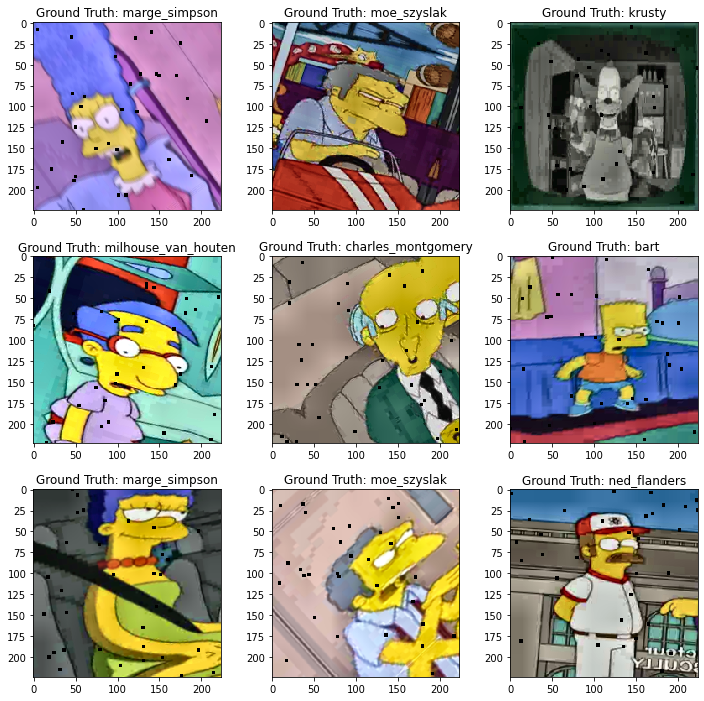

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [ ]:
### 임시로 1개의 batch를 돌려서 잘 작동하는지 확인(Test Set)
### Scaling을 제외한 Augmentation이 적용되면 안 됨!!!
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (164,)
Data  : (164, 224, 224, 3)


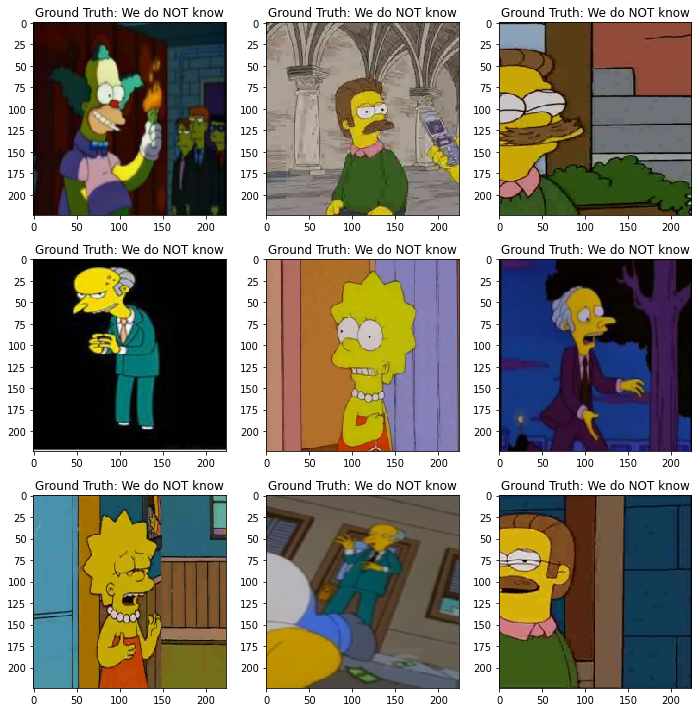

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()

## CNN Modeling (Xception)
이전 MNIST classification 때에는 size가 28 x 28이어서 전이학습을 하기 어려웠음. <br>
이번 Simpsons Classification의 경우에는 데이터의 size가 충분히 큰 관계로, 전이학습을 통해 정확도를 높이기로 함.

## CNN Modeling
Xception pretrained model을 사용할 때, 앞의 일정 epoch를 freeze시킴. <br>
여기에서 freeze는 weight를 계산하지 않고 pretrained model의 weight를 그대로 이용하여 학습하는 것을 의미함. <br>
정해진 만큼의 epoch가 진행되면, 이후에는 정상적으로 weight를 계산함.

In [ ]:
input_tensor= Input(shape=(224, 224, 3))

base_model = Xception(input_tensor=input_tensor, include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
x = Dense(128, activation="relu", name="FC")(x)
x = Dropout(rate=0.2)(x)
output = Dense(9, activation="softmax", name="Output")(x)


model = Model(inputs=input_tensor, outputs=output)

model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________

### Defining Learning Rate (Cosine Annealing)
Cyclical Learning Rate의 일종으로, local mimima에 갇히는 걸 피하고자 사용. <br>
Epoch 단위가 아닌 Step 단위로 정의되어 있기 때문에, Callback Function 안에 있는 <br>
Learning Rate Scheduler가 아닌, optimizer의 lr 변수로 이용됨. <br>
후술할 freezing 때문에 training을 2회 진행하므로, 두 개의 learning rate를 정의함.

In [ ]:
lr_Cosine_Decay_1 = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=5e-4, first_decay_steps=141,
    t_mul=2, m_mul=0.75, alpha=0.0, name=None
)

lr_Cosine_Decay_2 = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=(5e-4) * (0.75**4), first_decay_steps=141*16,
    t_mul=2, m_mul=0.75, alpha=0.0, name=None
)

In [ ]:
def plot_scheduler(epochs_list, lr_list, title=None):
    plt.figure(figsize=(6,4))
    plt.plot(epochs_list, lr_list)
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.title(title)

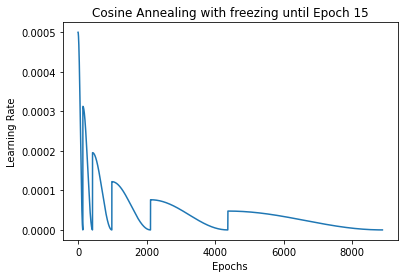

In [ ]:
steps_list = range(141 * 63)
lr_list_1 = [lr_Cosine_Decay_1(step) for step in range(141 * 15)]
lr_list_2 = [lr_Cosine_Decay_2(step) for step in range(141 * 63 - 141 * 15)]

plot_scheduler(steps_list, lr_list_1 + lr_list_2, title="Cosine Annealing with freezing until Epoch 15")

### Defining Callback Functions
Learning Rate는 위에서 정의하였고, Cosine Annealing의 특성 상 Early Stopping이 잘 적용되지 않으므로, <br>
Callback Function으로는 Model Checkpoint만 이용하기로 함.

In [ ]:
mdcp = ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/simpsons/Checkpoint/{epoch:02d}-{val_accuracy:.5f}.h5",
                       monitor="val_accuracy", verbose=1, save_best_only=True, mode="auto", save_freq="epoch")

In [ ]:
### Weight Normalization -> 적용하면 더 낮은 정확도가 나옴. 사용 보류.

print(num_list)
pprint(category)

class_weight = {}
for i, name in enumerate(target):
    foo = (np.sum(num_list) / (9 * num_list[i])) ** 2

    if foo > 1:
        class_weight[i] = foo
    else:
        class_weight[i] = 1.0

pprint(class_weight)

[1218, 1086, 1101, 1354, 1311, 1079, 1452, 1454, 1193]
{0: 'bart',
 1: 'charles_montgomery',
 2: 'krusty',
 3: 'lisa_simpson',
 4: 'marge_simpson',
 5: 'milhouse_van_houten',
 6: 'moe_szyslak',
 7: 'ned_flanders',
 8: 'principal_skinner'}
{0: 1.0528609539361418,
 1: 1.3243596670051117,
 2: 1.2885193906185202,
 3: 1.0,
 4: 1.0,
 5: 1.3415989419949654,
 6: 1.0,
 7: 1.0,
 8: 1.097449914826682}


## Experiment
논문에서 Cosine Annealing은 Ada 계열에서 적용할 것을 강조(SGD 등과는 안 어울림). <br>
Adam, Adagrad, Adadelta 등을 적용해 본 결과, Adam이 제일 결과가 좋아서 최종적으로 Adam을 적용함.

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay_1),
              loss="categorical_crossentropy", metrics=["accuracy"])

for layer in model.layers[:-5]:
    layer.trainable = False

first_epoch = 15
second_epoch = 63 - first_epoch

hist_1 = model.fit(train_loader, batch_size=train_batch_size, epochs=first_epoch,
                 validation_data=val_loader, verbose=1, class_weight=class_weight)

for layer in model.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

model.compile(optimizer=Adam(learning_rate=lr_Cosine_Decay_2),
              loss="categorical_crossentropy", metrics=["accuracy"])

hist_2 = model.fit(train_loader, batch_size=train_batch_size, epochs=second_epoch,
                   validation_data=val_loader, verbose=1, callbacks=[mdcp], class_weight=class_weight)

Epoch 1/15
141/141 [==============================] - 98s 650ms/step - loss: 0.5450 - accuracy: 0.8380 - val_loss: 0.1691 - val_accuracy: 0.9516
Epoch 2/15
141/141 [==============================] - 92s 653ms/step - loss: 0.1379 - accuracy: 0.9623 - val_loss: 0.1118 - val_accuracy: 0.9693
Epoch 3/15
141/141 [==============================] - 93s 658ms/step - loss: 0.0703 - accuracy: 0.9814 - val_loss: 0.0885 - val_accuracy: 0.9769
Epoch 4/15
141/141 [==============================] - 91s 639ms/step - loss: 0.0618 - accuracy: 0.9840 - val_loss: 0.1243 - val_accuracy: 0.9627
Epoch 5/15
141/141 [==============================] - 91s 643ms/step - loss: 0.0482 - accuracy: 0.9884 - val_loss: 0.0777 - val_accuracy: 0.9791
Epoch 6/15
141/141 [==============================] - 88s 625ms/step - loss: 0.0291 - accuracy: 0.9927 - val_loss: 0.0644 - val_accuracy: 0.9853
Epoch 7/15
141/141 [==============================] - 90s 636ms/step - loss: 0.0218 - accuracy: 0.9944 - val_loss: 0.0674 - val_ac

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/48
141/141 [==============================] - 89s 631ms/step - loss: 0.0296 - accuracy: 0.9926 - val_loss: 0.1446 - val_accuracy: 0.9618

Epoch 00002: val_accuracy did not improve from 0.97600
Epoch 3/48
141/141 [==============================] - 92s 648ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.1064 - val_accuracy: 0.9818

Epoch 00003: val_accuracy improved from 0.97600 to 0.98178, saving model to /content/drive/MyDrive/Colab Notebooks/simpsons/Checkpoint/03-0.98178.h5
Epoch 4/48
141/141 [==============================] - 92s 653ms/step - loss: 0.0280 - accuracy: 0.9923 - val_loss: 0.1047 - val_accuracy: 0.9707

Epoch 00004: val_accuracy did not improve from 0.98178
Epoch 5/48
141/141 [==============================] - 90s 639ms/step - loss: 0.0200 - accuracy: 0.9951 - val_loss: 0.0998 - val_accuracy: 0.9809

Epoch 00005: val_accuracy did not improve from 0.98178
Epoch 6/48
141/141 [==============================] - 91s 640ms/step - loss: 0.0226 - accuracy: 0.9948

In [ ]:
def acc_loss_plot_freeze(hist_1, hist_2):

    """
    hist_1: before freezing
    hist_2: after freezing
    """

    fit, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist_1.history["loss"] + hist_2.history["loss"],
                 "y", label="train_loss")
    loss_ax.plot(hist_1.history["val_loss"] + hist_2.history["val_loss"],
                 "r", label="val_loss")
    loss_ax.set_xlabel("Epoch")
    loss_ax.set_ylabel("Loss")
    loss_ax.legend(loc = "upper left")
    
    acc_ax.plot(hist_1.history["accuracy"] + hist_2.history["accuracy"],
                "b", label="train_acc")
    acc_ax.plot(hist_1.history["val_accuracy"] + hist_2.history["val_accuracy"],
                "g", label="val_acc")
    acc_ax.set_ylabel("Accuracy")
    acc_ax.legend(loc = "upper right")
    
    plt.show()

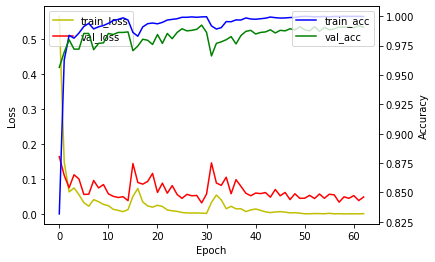

In [ ]:
acc_loss_plot_freeze(hist_1, hist_2)

## Making Answer sheets
Model Checkpoint에 의해서 저장된 Model들 중, validation accuracy 혹은 validation loss를 기준으로 하여 <br>
좋은 결과를 보여준 Model을 불러온 후, forecasting한 결과를 csv 파일로 저장.

In [ ]:
model = load_model("/content/drive/MyDrive/Colab Notebooks/simpsons/Checkpoint/15-0.99244.h5")

In [ ]:
def y_train_writting(test_set_pics, test_set_names):

    """
    test_set_pics: X_test(numpy ndarray) or test_loader(enumerable)
    test_set_names: y_test (pandas DataFrame)
    """

    pred_integral = np.argmax(model.predict(test_set_pics), axis=-1)

    pred_categorical = []

    for prediction in pred_integral:

        if 0 <= prediction <= 8:
            pred_categorical.append(category[prediction])
        
        else:
            raise ValueError("Not a valid integral prediction.")
    
    test_set_names["pred"] = pred_categorical
    print(test_set_names)

    tm = time.localtime()

    if 9 + tm.tm_hour >= 24:
        hour = 9 + tm.tm_hour - 24
        mday = 1 + tm.tm_mday
    else:
        hour = tm.tm_hour
        mday = tm.tm_mday

    file_name = "{0}{1}{2}_{3}{4}{5}".format(str(tm.tm_year).zfill(4),
                                             str(tm.tm_mon).zfill(2),
                                             str(mday).zfill(2),
                                             str(hour).zfill(2),
                                             str(tm.tm_min).zfill(2),
                                             str(tm.tm_sec).zfill(2))

    test_set_names.to_csv("/content/drive/MyDrive/Colab Notebooks/simpsons/answersheet/{0}.csv".format(file_name), mode="w")
    print("The answer sheet file is saved as {}.csv".format(file_name))

In [ ]:
y_train_writting(test_loader, y_test_list)